In [144]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Constants

X_MIN, X_MAX, Y_MIN, Y_MAX = 0, 10, 0, 10
obs_dim = 10
state_dim = 2

# Centroids
centroids = []
for x in (X_MAX//4, X_MAX * 3//4):
    for y in (Y_MAX//4, Y_MAX * 3//4):
        centroids.append(np.array((x, y)))

rooms = []
for x in (X_MAX//2, X_MAX):
    for y in (Y_MAX//2, Y_MAX):
        rooms.append((x-X_MAX//2, y-Y_MAX//2, x, y))
def initiation_set(room_limits):
    def _init(state):
        low_limit = room_limits[0:2]
        high_limit = room_limits[2:]
        return not (state[0] > low_limit[0] and state[0] < high_limit[0] and state[1] > low_limit[1] and state[1] < high_limit[1])
    return _init
# Synthetic option definition

effect_dists_params = []
initiation_sets = []
std_dev = 1
for i, room in enumerate(rooms):
    initiation_sets.append(initiation_set(room))
    effect_dists_params.append((centroids[i], std_dev))

In [183]:
# Data Generation

N = 1000

x = np.random.uniform(0, X_MAX, N)
y = np.random.uniform(0, Y_MAX, N)

s = np.array((x,y)).T

masks = []
for i, init_set in enumerate(initiation_sets):
    mask = np.zeros((N,1))
    for j in range(N):
        mask[j] = float(init_set(s[j]))
    masks.append(mask)

masks = np.array(masks)
I_s = np.array(masks).transpose((1,0,2))[...,0] # initiation vector at s

# generate next states
s_prime = []
for i, effect_dist in enumerate(effect_dists_params):
    s_prime.append(np.random.multivariate_normal(effect_dist[0], effect_dist[1] * np.eye(2), size=N))


s_prime = np.array(s_prime) * masks  + s[np.newaxis] * (1-masks)
masks = masks.reshape((-1,))

I_s_prime = []
for action in range(len(initiation_sets)):
    _m = np.zeros((N,len(initiation_sets)))
    for i, init_set in enumerate(initiation_sets):
        for j in range(N):
            _m[j, i] = float(init_set(s_prime[action][j]))
    I_s_prime.append(_m)

# Random affine transformation

T = np.random.rand(obs_dim, state_dim)
x = np.einsum('ij, kj->ki', T, s)
x_prime = np.einsum('ij, lkj->lki', T, s_prime)

data = []
for i in range(len(effect_dists_params)):
    data.append((x, x_prime[i], I_s, I_s_prime[i], s, s_prime[i]))

In [175]:
# Model
hidden_size = 64
n_actions = len(initiation_sets)


initiation_classifier = nn.Sequential(
                                    nn.Linear(obs_dim, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size//2),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size//2, n_actions),
                                    nn.Sigmoid()
                                )

In [176]:
def minibatches(in_data, out_data, batch_size):
    N = in_data.size(0)
    n_batches = N//batch_size + int(N%batch_size != 0)
    for i in range(n_batches):
        yield (in_data[i*batch_size:(i+1)*batch_size], out_data[i*batch_size:(i+1)*batch_size])

# permute data

def permute_data(in_data, out_data):
    rand_order = torch.randperm(in_data.size(0))
    _in = torch.index_select(in_data, 0, rand_order)
    _out = torch.index_select(out_data, 0, rand_order)
    return _in, _out

In [184]:
# training
n_epochs = 200
minibatch_size = 2**5


optimizer_classifier = torch.optim.Adam(initiation_classifier.parameters(), lr=1e-3)
action = 0
obs, obs_prime = torch.from_numpy(data[action][0]), torch.from_numpy(data[action][1])
I, I_prime = torch.from_numpy(data[action][2]), torch.from_numpy(data[action][3])
print(I_prime.shape)

in_data = torch.cat((obs, obs_prime), dim=0)
out_data = torch.cat((I, I_prime), dim=0)

for _ in range(n_epochs):
    for _in, _out in minibatches(in_data, out_data, minibatch_size):
        _in = _in.float()
        _out = _out.float()
        
        # Predict initiation vector from (z, z')
        predicted_I_s = initiation_classifier(_in)
        _initiations = _out
        # binary classifier loss
        # _classifier_loss = (torch.log(predicted_I_s) * _initiations + torch.log(1-predicted_I_s) * (1-_initiations)).mean()
        _classifier_loss = nn.BCELoss()(predicted_I_s.squeeze(), _initiations)
        print(f"{_classifier_loss}")

        _target = _out
        _loss = _classifier_loss
        
        ### zero grads 
        optimizer_classifier.zero_grad()
        ### backward pass
        _loss.backward()
        
        ### update
        optimizer_classifier.step()

torch.Size([1000, 4])
0.696289598941803
0.6704049706459045
0.6570127010345459
0.6517263650894165
0.6302596926689148
0.6090853214263916
0.6118783950805664
0.6123908162117004
0.589722216129303
0.58719402551651
0.5968769192695618
0.5665297508239746
0.5665392875671387
0.5552076101303101
0.5685461759567261
0.5598503351211548
0.5632389783859253
0.5502004027366638
0.5547876358032227
0.5718165040016174
0.5997099280357361
0.5475134253501892
0.5842201113700867
0.552764892578125
0.5568841099739075
0.5749133825302124
0.6016841530799866
0.5518507957458496
0.53317791223526
0.5396704077720642
0.5880682468414307
0.6316739916801453
0.6525802612304688
0.6460430026054382
0.638944149017334
0.6214800477027893
0.6095897555351257
0.5937486886978149
0.5795708298683167
0.550888180732727
0.5335851311683655
0.5261465907096863
0.508855938911438
0.4945295453071594
0.4586407542228699
0.4318481981754303
0.42729055881500244
0.410023033618927
0.38777241110801697
0.3518941402435303
0.31841951608657837
0.286322295665740

(4, 1000, 2)


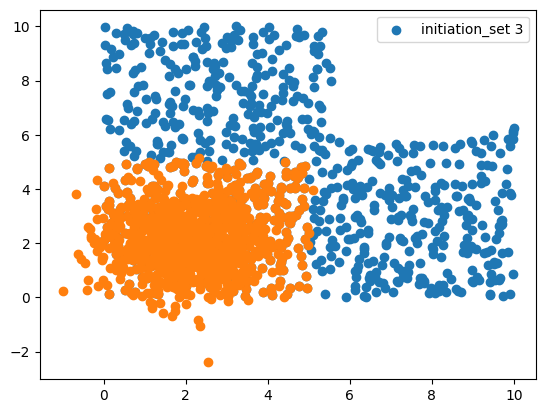

In [196]:
print(s_prime.shape)
with torch.no_grad():
    x = torch.from_numpy(data[0][0]).float()
    logits = initiation_classifier(x)
    init_masks = logits
    i = 3
    plt.scatter(s[init_masks[...,i] > 0.7, 0], s[init_masks[...,i] > 0.7, 1], label=f"initiation_set {i}")
    plt.scatter(s_prime[action][I_s_prime[action][..., i] == 1, 0], s_prime[action][I_s_prime[action][...,i] == 1, 1])

    plt.legend()
    plt.show()